In [ ]:
"""
1. Split the original train data to train and validation set
2. Perform OneHotEncoding on the (originally) categorical variables
3. Perform scaling of continuous variables and combine with vategorical variables
4. Repeat with validation and test set

Quickly fit to baseline models

5. On each fold perform oversampling for imbalance classes


"""

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score, log_loss

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [28]:
# Load data
df_train = pd.read_pickle('../dump/df_train_knnimputed.csv')
df_test = pd.read_pickle('../dump/df_test_knnimputed.csv')

In [29]:
df_train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,25.0,4.0,0.0,1.0,36.0,1.0
1,29725.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,15.0,2.0,0.0,5.0,47.0,0.0
2,11561.0,2.0,1.0,0.0,0.0,2.0,2.0,0.0,5.0,2.0,0.0,0.0,83.0,0.0
3,33241.0,3.0,1.0,1.0,0.0,1.0,2.0,1.0,0.0,1.0,0.0,0.0,52.0,1.0
4,666.0,4.0,1.0,0.0,1.0,0.0,3.0,0.0,25.0,2.0,1.0,4.0,8.0,0.0


In [30]:
df_test.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
19158,32403.0,24.0,1.0,0.0,1.0,2.0,2.0,0.0,9.0,0.0,0.0,1.0,21.0,1.0
19159,9858.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,5.0,5.0,0.0,1.0,98.0,0.0
19160,31806.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,15.0,1.0
19161,27385.0,10.0,1.0,0.0,1.0,0.0,3.0,0.0,11.0,1.0,0.0,1.0,39.0,0.0
19162,27724.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,25.0,7.0,0.0,5.0,72.0,1.0


## 1. Split to train and validation set

In [31]:
# Train, validation set
X = df_train.iloc[:,:-1]
y = df_train['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=2)

In [32]:
# Test set
X_test = df_test.iloc[:,:-1]
y_test = df_test['target']

## Treat continuous and categorical variables separately and then combine

#### Train set

In [33]:
# Continuous variables
features = ['city_development_index', 'training_hours', 'experience', 'last_new_job']
X_train_con = X_train[features]


# Since we're using more than one feature, let's scale our features
scaler = StandardScaler()
X_train_con_scaled = scaler.fit_transform(X_train_con)
cont_columns = X_train_con.columns
X_train_con_df = pd.DataFrame(X_train_con_scaled, columns=cont_columns, index=X_train_con.index)

# Categorical variables
cat_variables = ['relevent_experience','enrolled_university','education_level','major_discipline','company_size','company_type']
X_train_cat = X_train[cat_variables]

ohe = OneHotEncoder(sparse=False, drop='first')
ohe.fit(X_train_cat) 
cats = ohe.transform(X_train_cat)

columns = ohe.get_feature_names(cat_variables)
X_train_cat_df = pd.DataFrame(cats, columns=columns, index=X_train_cat.index)

# Combine Con and Cat
X_train = pd.concat([X_train_con_df,X_train_cat_df], axis='columns')

X_train

,city_development_index,training_hours,experience,last_new_job,relevent_experience_1.0,enrolled_university_1.0,enrolled_university_2.0,education_level_1.0,education_level_2.0,education_level_3.0,...,company_size_3.0,company_size_4.0,company_size_5.0,company_size_6.0,company_size_7.0,company_type_1.0,company_type_2.0,company_type_3.0,company_type_4.0,company_type_5.0
1523,-17.363503,-0.289945,-0.097795,1.804853,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
590,0.057592,-0.838882,-0.853930,-0.600362,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4281,0.057592,-0.256676,1.792542,1.804853,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10430,0.057592,-0.922055,0.154250,-1.201666,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13145,0.057592,2.305034,-1.105975,-1.201666,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099,0.057592,-0.872151,-0.097795,1.203549,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18898,0.057592,-0.988593,0.532317,1.804853,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
11798,0.057592,0.907738,1.792542,1.203549,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6637,0.057592,-0.289945,-0.475862,0.000942,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


#### Validation set

In [34]:
# Continuous variables
features = ['city_development_index', 'training_hours', 'experience', 'last_new_job']
X_val_con = X_val[features]


# Since we're using more than one feature, let's scale our features
scaler = StandardScaler()
X_val_con_scaled = scaler.fit_transform(X_val_con)
cont_columns = X_val_con.columns
X_val_con_df = pd.DataFrame(X_val_con_scaled, columns=cont_columns, index=X_val_con.index)

# Categorical variables
cat_variables = ['relevent_experience','enrolled_university','education_level','major_discipline','company_size','company_type']
X_val_cat = X_val[cat_variables]

ohe = OneHotEncoder(sparse=False, drop='first')
ohe.fit(X_val_cat) 
cats = ohe.transform(X_val_cat)

columns = ohe.get_feature_names(cat_variables)
X_val_cat_df = pd.DataFrame(cats, columns=columns, index=X_val_cat.index)

# Combine Con and Cat
X_val = pd.concat([X_val_con_df,X_val_cat_df], axis='columns')

X_val

,city_development_index,training_hours,experience,last_new_job,relevent_experience_1.0,enrolled_university_1.0,enrolled_university_2.0,education_level_1.0,education_level_2.0,education_level_3.0,...,company_size_3.0,company_size_4.0,company_size_5.0,company_size_6.0,company_size_7.0,company_type_1.0,company_type_2.0,company_type_3.0,company_type_4.0,company_type_5.0
13484,0.056048,-0.903854,1.764899,1.195656,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5554,0.056048,-0.719037,1.764899,-0.600171,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9345,0.056048,-0.315800,-0.735690,-0.600171,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18622,0.056048,0.121039,-0.360602,1.794265,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11704,0.056048,-0.349404,-0.485631,-0.600171,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12726,0.056048,-0.618228,-1.360837,-0.600171,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8859,0.056048,0.121039,1.764899,1.195656,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
15821,0.056048,0.625086,1.764899,-0.600171,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2626,0.056048,0.205047,1.764899,-0.600171,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Test set

In [35]:
# Continuous variables
features = ['city_development_index', 'training_hours', 'experience', 'last_new_job']
X_test_con = X_test[features]


# Since we're using more than one feature, let's scale our features
scaler = StandardScaler()
X_test_con_scaled = scaler.fit_transform(X_test_con)
cont_columns = X_test_con.columns
X_test_con_df = pd.DataFrame(X_test_con_scaled, columns=cont_columns, index=X_test_con.index)

# Categorical variables
cat_variables = ['relevent_experience','enrolled_university','education_level','major_discipline','company_size','company_type']
X_test_cat = X_test[cat_variables]

ohe = OneHotEncoder(sparse=False, drop='first')
ohe.fit(X_test_cat) 
cats = ohe.transform(X_test_cat)

columns = ohe.get_feature_names(cat_variables)
X_test_cat_df = pd.DataFrame(cats, columns=columns, index=X_test_cat.index)

# Combine Con and Cat
X_test= pd.concat([X_test_con_df,X_test_cat_df], axis='columns')

X_test

,city_development_index,training_hours,experience,last_new_job,relevent_experience_1.0,enrolled_university_1.0,enrolled_university_2.0,education_level_1.0,education_level_2.0,education_level_3.0,...,company_size_3.0,company_size_4.0,company_size_5.0,company_size_6.0,company_size_7.0,company_type_1.0,company_type_2.0,company_type_3.0,company_type_4.0,company_type_5.0
19158,0.053162,-0.730319,-0.227252,-0.615812,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19159,0.053162,0.548230,-0.722840,-0.615812,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19160,0.053162,-0.829946,-1.342326,-1.224477,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19161,0.053162,-0.431437,0.020543,-0.615812,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19162,0.053162,0.116513,1.755103,1.818848,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21282,0.053162,-0.829946,0.640029,1.210183,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
21283,0.053162,-0.580878,0.887823,-0.007147,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21284,0.053162,-0.780132,-0.970635,-1.224477,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21285,0.053162,0.315767,-0.475046,-0.615812,1.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Pickle

In [36]:
X_train.to_pickle('../dump/X_train_processed_knnimputed')
X_val.to_pickle('../dump/X_val_processed_knnimputed')
X_test.to_pickle('../dump/X_test_processed_knnimputed')

## 2. Handle Imbalanced Classes

Oversampling only in train set.

#### Train set

In [51]:
from imblearn.over_sampling import ADASYN
X_adasyn, y_adasyn = ADASYN(random_state=42).fit_sample(X_train,y_train)

In [53]:
from collections import Counter
Counter(y_adasyn)

Counter({1.0: 12858, 0.0: 12932})

In [54]:
X_train, y_train = X_adasyn, y_adasyn

### 1. Logistic Regression

In [69]:
lm = LogisticRegression(solver='newton-cg',  # For comparison, use the same solver as statsmodels default
                          C=100000)  # No regularization

lm.fit(X_train, y_train)
print('intercept: ', round(lm.intercept_[0], 4))
print('Accuracy score:',accuracy_score(lm.predict(X_train),y_train))
pd.DataFrame(list(zip(cat_variables,np.transpose(lm.coef_))),columns=['Feature','Coef'])\
.sort_values('Coef',ascending=False)

intercept:  -1.5909
Accuracy score: 0.6121364870104692


,Feature,Coef
3,major_discipline,[0.02526860380743496]
1,enrolled_university,[-0.06320491611095755]
0,relevent_experience,[-0.0676503721079165]
5,company_type,[-0.14530559844307436]
4,company_size,[-0.30187462930960857]
2,education_level,[-0.32507994279954894]


In [56]:
y_predict = lm.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_predict),\
             columns=['Predict-not changing (0)','Predict-change (1)'],\
            index=['Not changing (0)','Changing (1)'])

,Predict-not changing (0),Predict-change (1)
Not changing (0),945,608
Changing (1),206,370


In [111]:
pd.DataFrame(lm.predict_proba(X_test)).sort_values(1,ascending=False)

,0,1
101,0.095292,0.904708
649,0.115704,0.884296
918,0.123474,0.876526
1031,0.168285,0.831715
23,0.177585,0.822415
...,...,...
411,0.873863,0.126137
702,0.879150,0.120850
1421,0.895268,0.104732
1448,0.903385,0.096615


In [57]:
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['Not Looking', 'Looking'],
           yticklabels=['Not Looking', 'Looking']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

In [58]:
# Let's see how our confusion matrix changes with changes to the cutoff! 

from ipywidgets import interactive, FloatSlider
interactive(lambda threshold: make_confusion_matrix(lm, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [59]:
print('Accuracy score:',accuracy_score(y_test,y_predict),'\n')
print('Classification report (Logistic regression):\n\n',classification_report(y_test,y_predict))

Accuracy score: 0.6176608736496008 

Classification report (Logistic regression):

               precision    recall  f1-score   support

         0.0       0.82      0.61      0.70      1553
         1.0       0.38      0.64      0.48       576

    accuracy                           0.62      2129
   macro avg       0.60      0.63      0.59      2129
weighted avg       0.70      0.62      0.64      2129



In [60]:
df_test['proba_change'] = lm.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(df_test['target'],
                                 df_test['proba_change'])

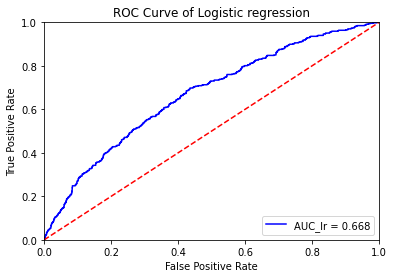

In [61]:
# Logistic regression ROC curve
# Validation set
y_scores = lm.predict_proba(X_val)
fpr, tpr, threshold = roc_curve(y_val, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC_lr = %0.3f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Logistic regression')
plt.show()

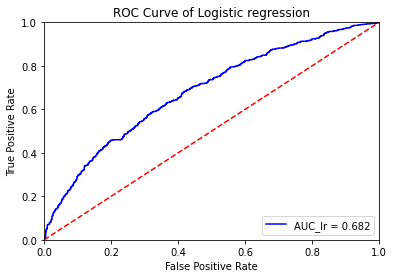

In [62]:
# Logistic regression ROC curve
y_scores = lm.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC_lr = %0.3f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Logistic regression')
plt.show()

### 2. KNN

In [63]:
from sklearn.neighbors import KNeighborsClassifier

knn_3 = KNeighborsClassifier(n_neighbors=3)
knn_3.fit(X_train,y_train)
pred = knn_3.predict(X_test)

print('Accuracy score:',accuracy_score(y_test,pred),'\n')
print('Classification report (kNN, n=3):\n\n',classification_report(y_test,pred))

Accuracy score: 0.5857209957726632 

Classification report (kNN, n=3):

               precision    recall  f1-score   support

         0.0       0.76      0.64      0.69      1553
         1.0       0.31      0.45      0.37       576

    accuracy                           0.59      2129
   macro avg       0.54      0.54      0.53      2129
weighted avg       0.64      0.59      0.60      2129



In [64]:
knn_5 = KNeighborsClassifier(n_neighbors=5)
knn_5.fit(X_train,y_train)
pred = knn_5.predict(X_test)

print('Accuracy score:',accuracy_score(y_test,pred),'\n')
print('Classification report (kNN, n=5):\n\n',classification_report(y_test,pred))

Accuracy score: 0.5819633630812588 

Classification report (kNN, n=5):

               precision    recall  f1-score   support

         0.0       0.78      0.60      0.68      1553
         1.0       0.33      0.53      0.41       576

    accuracy                           0.58      2129
   macro avg       0.55      0.57      0.54      2129
weighted avg       0.66      0.58      0.60      2129



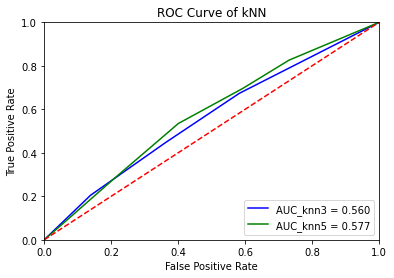

In [65]:
# knn (n=3)
y_scores = knn_3.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC_knn3 = %0.3f' % roc_auc)

# knn (n=5)
y_scores = knn_5.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'g', label = 'AUC_knn5 = %0.3f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()

### 3. Naive Bayes

In [66]:
nb = GaussianNB()
nb.fit(X_train,y_train)
pred = nb.predict(X_test)
print('Accuracy score:',accuracy_score(y_test,pred),'\n')
print('Classification report (Naive Bayes):\n\n',classification_report(y_test,pred))

Accuracy score: 0.4617191169563175 

Classification report (Naive Bayes):

               precision    recall  f1-score   support

         0.0       0.80      0.35      0.49      1553
         1.0       0.30      0.77      0.44       576

    accuracy                           0.46      2129
   macro avg       0.55      0.56      0.46      2129
weighted avg       0.67      0.46      0.47      2129



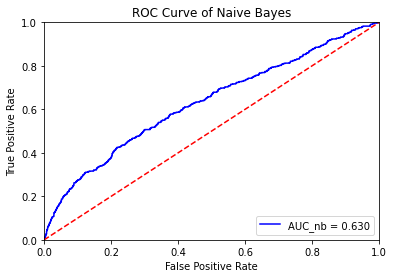

In [67]:
# Naive Bayes ROC curve
y_scores = nb.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC_nb = %0.3f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Naive Bayes')
plt.show()

In [50]:
# Naive Bayes model has higher recall!

### 4. XGBoost

In [76]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score


xgb = XGBClassifier()
xgb.fit(X_train, y_train)

y_train_pred = xgb.predict_proba(X_train)
y_train_pred_pos = y_train_pred[:,1]

y_val_pred = xgb.predict_proba(X_val)
y_val_pred_pos = y_val_pred[:,1]

auc_train = roc_auc_score(y_train, y_train_pred_pos)
auc_val = roc_auc_score(y_val, y_val_pred_pos)

print('Train AUC Score', auc_train)
print('Validation AUC Score', auc_val)

fpr, tpr, _ = roc_curve(y_val, y_val_pred_pos)

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:50:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train AUC Score 0.9347312999011737
Validation AUC Score 0.5856686217918878


In [ ]:
# Still overfitting!

In [79]:
pred = xgb.predict(X_test)
print('Accuracy score:',accuracy_score(y_test,pred))
print('Test AUC Score', roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1]),'\n')
print('Classification report (XGBoost):\n\n',classification_report(y_test,pred))

Accuracy score: 0.2775951150775012
Test AUC Score 0.5914158081133291 

Classification report (XGBoost):

               precision    recall  f1-score   support

         0.0       0.94      0.01      0.02      1553
         1.0       0.27      1.00      0.43       576

    accuracy                           0.28      2129
   macro avg       0.61      0.50      0.22      2129
weighted avg       0.76      0.28      0.13      2129



In [ ]:
# Compared to pre-ADASYN, AUC is lower but recall is 100% now.

In [80]:
xgb = XGBClassifier( 
        n_estimators=30000,
        max_depth=4,
        objective='binary:logistic', #new objective
        use_label_encoder=False,
        learning_rate=.05, 
        subsample=.2,
        min_child_weight=2,
        colsample_bytree=.5)

eval_set=[(X_train,y_train),(X_val,y_val)]

fit_model = xgb.fit(
                X_train, y_train, 
                eval_set=eval_set,
                eval_metric='auc', #auc
                early_stopping_rounds=50,
                verbose=False)

accuracy_score(y_test, xgb.predict(X_test, ntree_limit=xgb.best_ntree_limit)) 
pred = xgb.predict(X_test, ntree_limit=xgb.best_ntree_limit)
print('Accuracy score:',accuracy_score(y_test,pred))
print('ROC AUC score:',roc_auc_score(y_test,xgb.predict_proba(X_test)[:, 1]),'\n')
print('Classification report (XGBoost):\n\n',classification_report(y_test,pred))

Accuracy score: 0.43024894316580553
ROC AUC score: 0.6496247182871862 

Classification report (XGBoost):

               precision    recall  f1-score   support

         0.0       0.85      0.26      0.40      1553
         1.0       0.31      0.88      0.45       576

    accuracy                           0.43      2129
   macro avg       0.58      0.57      0.43      2129
weighted avg       0.70      0.43      0.42      2129



In [88]:
xgb = XGBClassifier( 
        n_estimators=10000,
        max_depth=2,
        objective='binary:logistic', #new objective
        use_label_encoder=False,
        learning_rate=.05, 
        subsample=.2,
        min_child_weight=3,
        colsample_bytree=.1)

eval_set=[(X_train,y_train),(X_val,y_val)]

fit_model = xgb.fit(
                X_train, y_train, 
                eval_set=eval_set,
                eval_metric='auc', #auc
                early_stopping_rounds=50,
                verbose=False)

accuracy_score(y_test, xgb.predict(X_test, ntree_limit=xgb.best_ntree_limit)) 
pred = xgb.predict(X_test, ntree_limit=xgb.best_ntree_limit)
print('Accuracy score:',accuracy_score(y_test,pred))
print('ROC AUC score:',roc_auc_score(y_test,xgb.predict_proba(X_test)[:, 1]),'\n')
print('Classification report (XGBoost):\n\n',classification_report(y_test,pred))

Accuracy score: 0.6923438233912635
ROC AUC score: 0.6385250098375903 

Classification report (XGBoost):

               precision    recall  f1-score   support

         0.0       0.77      0.82      0.79      1553
         1.0       0.42      0.36      0.39       576

    accuracy                           0.69      2129
   macro avg       0.60      0.59      0.59      2129
weighted avg       0.68      0.69      0.68      2129



In [104]:
pd.DataFrame(xgb.predict_proba(X_test)).sort_values(1)

,0,1
647,0.589569,0.410431
655,0.568061,0.431939
280,0.565194,0.434805
338,0.560972,0.439028
766,0.560851,0.439149
...,...,...
1720,0.467437,0.532563
1228,0.467437,0.532563
1987,0.467437,0.532563
918,0.455943,0.544057


In [103]:
pd.DataFrame(xgb.predict(X_test))

,0
0,1
1,0
2,0
3,0
4,0
...,...
2124,0
2125,0
2126,0
2127,0
